## 1. Problem Definition

The following project has to do with the market for repossesed assets in the Spanish market. There is a public website that exposes current and past auctions.

- There are several types of assets ranging from apartments to rustic/agricultural land.
- Not all the data is exposed through the website so it's critical to have something to collect and save data before stops being exposed.
- There is no public API so scraping is required. Given there is no usage of new technology it is actually quite easy.

The main goal of this project is having a tool that basically allows us to separate the chaff from the wheat. There is a significant amount of empty auctions and also non-empty ones with low quality assets so it's critical to have sort of accurate tool to have an initial filter so then we can perform a manual analysis of each opportunity without losing too much time.

For this reason is why we want to focus on predicting two key aspects.
- If a given auction is going to be empty or not.
- If an auction is going to be disputed, what is the approximate amoutn we expect to bid in case we want to acquire the asset.


## 2. Data gathering

For this part we have relied on a library called Puppeteer developed by Google. It might feel as an overkill but at the moment of development it was the tool we were mostly used to so we opted for using this to be able to develop something quickly, not necesarily perfect.

Initially we set our expectations quite high with regards to the amount of new data to be ready to be scraped from the auction site. Turns out we deeply overestimated this.
Initially expectation was set at around 6000-10000 records per week. At the moment we estimate around 800-1200 per week.

Some 3rd party services were used to get more meaningful data. Concretely, Google Geovode API was used to turn postal codes into coordinates so we can have some sort of continous variable for location purposes.


## 3. Preparing Data for Consumption


In [30]:
# Imports
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# Constants
ROOT_DIR = os.getcwd()
PATH_TO_CSVS = os.path.join(ROOT_DIR, "results/csv")

The following is an example on how the data looks like.

In this case, it is a JSON file for a single auction item.

In [32]:
path_to_example = os.path.join(ROOT_DIR, "results/details/SUB-AT-2018-18R4586001028.json")

with open(path_to_example) as file:
    jsonData = json.load(file)

print(json.dumps(jsonData, indent=4, sort_keys=True)) 

{
    "autoridad_gestora": {
        "codigo": "R45860",
        "correo_electronico": "subastas.castillalamancha@correo.aeat.es",
        "descripcion": "U.R. SUBASTAS CASTILLA-MANCHA (AEAT)",
        "direccion": "PZ TENDILLAS 1 ; 45002 TOLEDO",
        "fax": "-",
        "telefono": "925287719"
    },
    "bienes": {
        "cargas": "0,00 \u20ac",
        "codigo_postal": "02002",
        "descripcion": "URBANA. GARAJE EN CALLE ANGEL, N\u00ba 19, PLANTA BAJA, SUPERFICIE UTIL, 10,13 M2. CUOTA DE PARTICIPACI\u00d3N DE UN ENTERO Y SEIS CENTESIMAS POR CIENTO.",
        "direccion": "CL ANGEL 19 0",
        "idufir": "02011000745776",
        "inscripcion_registral": "BIEN INSCRITO EN REGISTRO N\u00daM. 4 DE ALBACETE TOMO: 2373 , FOLIO: 191 , LIBRO: 681. FINCA: 36248 , INSCRIPCI\u00d3N: 1",
        "localidad": "ALBACETE",
        "provincia": "Albacete",
        "referencia_catastral": "9961014WJ9196B0019UA",
        "situacion_posesoria": "No consta",
        "titulo_juridico": "PLE

In [33]:
def loading_auction_data(filename, path=PATH_TO_CSVS):
    csv_path = os.path.join(path, filename)
    return pd.read_csv(csv_path)

auctions = loading_auction_data("allAuctions1.csv")

auctions_copy = auctions.copy(deep=True)

In [34]:
auctions_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8608 entries, 0 to 8607
Data columns (total 7 columns):
subId                   8608 non-null object
estimatedValue          8608 non-null float64
debtAmount              8608 non-null float64
independentValuation    8608 non-null float64
longitude               8462 non-null float64
latitude                8462 non-null float64
maxBid                  8608 non-null float64
dtypes: float64(6), object(1)
memory usage: 470.9+ KB


In [35]:
auctions_copy.sample(10)

,subId,estimatedValue,debtAmount,independentValuation,longitude,latitude,maxBid
4230,SUB-JA-2018-97949,467764.20,581284.31,0.00,-6.099698,40.036150,327434.94
7030,SUB-JC-2020-144361,2227.85,6936991.16,0.00,-2.037116,39.313244,100.00
4481,SUB-JA-2019-118016,112299.00,112299.00,0.00,-3.753666,43.316306,33689.70
533,SUB-JA-2015-1371,273065.22,0.01,0.00,-3.644582,40.422369,82821.71
2835,SUB-JA-2018-102561,137605.95,76510.13,0.00,-6.290714,36.798736,96323.85
5503,SUB-JA-2019-131469,70389.00,1919.67,0.00,-4.516040,36.626557,63350.10
8445,SUB-NV-2019-395882,3606.07,33458.71,3606.07,-16.717567,28.081772,0.00
2513,SUB-JA-2017-80508,306326.75,159781.19,306326.75,2.051815,41.567965,136827.61
6660,SUB-JA-2020-142756,129050.00,17325.76,129050.00,2.852724,41.978504,84500.00
7848,SUB-NE-2018-335715,249199.59,205501.55,249199.59,2.673541,41.635034,0.00


In [46]:
print(auctions_copy["longitude"].isnull().sum())
auctions_copy = auctions_copy.drop(auctions_copy.loc[auctions["longitude"].isnull()].index)


146


In [70]:
print(auctions_copy.isnull().sum())

subId                   0
estimatedValue          0
debtAmount              0
independentValuation    0
longitude               0
latitude                0
maxBid                  0
dtype: int64


In [90]:

selectedRows = auctions_copy.loc[
    auctions_copy["estimatedValue"] > 100
].loc[
    auctions_copy["independentValuation"] > 100
]

selectedRows["estimatedValueToValuationRatio"] = selectedRows["estimatedValue"]/selectedRows["independentValuation"]

rows_with_discrepancies = selectedRows.loc[selectedRows["estimatedValueToValuationRatio"] != 1.0].shape[0]

percentage_of_discrepancies = round(rows_with_discrepancies/selectedRows.shape[0] * 100, 3)

print(f'{percentage_of_discrepancies}% of instances where estimatedValue and independentValuation diverge')

6.995% of instances where estimatedValue and independentValuation diverge


After this discovery is better to assume in favour of simplicity to drop the **"independentValuation"** feature

## 4. Exploratory Analysis

Here we are going to proceed to visualize the data using matplotlib to have a better understanding of the data properties and how is distributed.

In [9]:
auctions.describe().apply(lambda s: s.apply(lambda x: '%.3f' % x))


,estimatedValue,debtAmount,independentValuation,longitude,latitude,maxBid
count,8608.000,8608.000,8608.000,8462.000,8462.000,8608.000
mean,319296.266,369986.822,136561.798,-3.231,39.092,127470.220
std,2167273.812,5316944.362,2106269.634,4.589,3.455,364756.723
min,0.000,0.000,0.000,-17.913,27.763,0.000
25%,61515.812,19795.408,0.000,-4.831,37.747,10359.225
50%,152481.500,82469.175,0.000,-3.629,40.055,67776.955
75%,270982.238,169027.395,40049.448,-0.203,41.369,137437.515
max,180000000.000,366426481.750,180000000.000,4.287,43.752,12737000.000


No handles with labels found to put in legend.


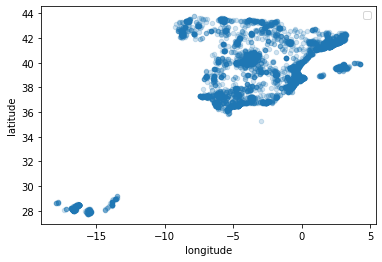

In [10]:
auctions.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2)
plt.legend()

##### Some observations

Seems we have the case of heavy tailing in most of the features. Concretely, has a high positive skewness.

Originally we were using Postal Code, in a effort to turn it into a continuous variable we leveraged on Goolgle Geocode API to turn it into geographic coordinates.
There were some instances where Google was not gicing the right coordinates but this was fixed by passing extra contextual data.

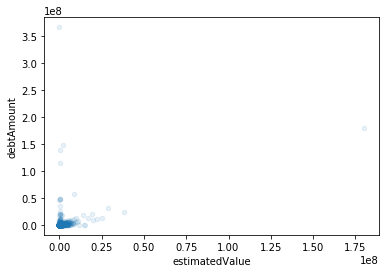

In [11]:
auctions.plot(kind="scatter", x="estimatedValue", y="debtAmount", alpha=0.1)

In [42]:
estimatedValues = auctions["estimatedValue"]
debtAmounts = auctions["debtAmount"]

count_with_value_estimation = 0
count_with_debt_amount = 0

for e in estimatedValues:
    if e != 0:
        count_with_debt_amount += 1

for e in debtAmounts:
    if e != 0.0:
        count_with_value_estimation += 1


print(f'This many samples with provided data for "debtAmount": {count_with_debt_amount}\n')

print(f'This many samples with provided data for "estimatedValue": {count_with_value_estimation}\n')

This many samples with provided data for "debtAmount": 8590

This many samples with provided data for "estimatedValue": 7893



In [52]:
auctions.loc[auctions["estimatedValue"] == 0.01]

,subId,estimatedValue,debtAmount,independentValuation,longitude,latitude,maxBid


In [45]:
# auctions["estimatedValue"].isnull().sum()

pd.qcut(auctions["estimatedValue"], 30)

0         (11200.0, 17709.176]
1          (3004.554, 6990.96]
2           (6990.96, 11200.0]
3           (6990.96, 11200.0]
4           (6990.96, 11200.0]
                 ...          
8603      (17709.176, 26774.0]
8604        (-0.001, 3004.554]
8605        (6990.96, 11200.0]
8606      (11200.0, 17709.176]
8607    (54610.224, 67231.172]
Name: estimatedValue, Length: 8608, dtype: category
Categories (30, interval[float64]): [(-0.001, 3004.554] < (3004.554, 6990.96] < (6990.96, 11200.0] < (11200.0, 17709.176] ... (395874.0, 479865.915] < (479865.915, 654807.302] < (654807.302, 1214151.19] < (1214151.19, 180000000.0]]

In [187]:
auctions["estimatedValue"].skew()

70.73160540465118

### Some observations on the previous data

Turns out the data it's strongly skewed (positive skew). The purpose of this analysis, is detecting patterns in the auctions to use that intelligence to predict interesting auctions in the future.
Given the outliers will be far from our reach in economic terms, the option choosen to get a more normal distribution would be to simply remove those outliers.
Same will be done for the elements with a valuation of 0 given this is one of the most important properties in our dataset.

<em>**Clarification**: We are talking about repossessed assets with valuations of 2/3 million +. Given that an average person doesn't use all his capital for this type of business, makes sense the decision of removing those elements falling above this threshold.</em>

In [30]:
EST_VALUE_UPPER_THRESSHOLD = 1500000
DEBT_RATIO_UPPER_THRESHOLD = 5

auctions_copy = auctions.copy()

auctions_copy.drop(
    auctions_copy[
        (auctions_copy["estimatedValue"] > EST_VALUE_UPPER_THRESSHOLD) |
        (auctions_copy["estimatedValue"] == 0) |
        (np.isnan(auctions_copy["debtAmount"]) == True) |
        (auctions_copy["debtAmount"]/auctions_copy["estimatedValue"] > DEBT_RATIO_UPPER_THRESHOLD)
    ].index, inplace=True)

print(len(auctions_copy["estimatedValue"]))
print(len(auctions_copy["debtAmount"]))

7986
7986


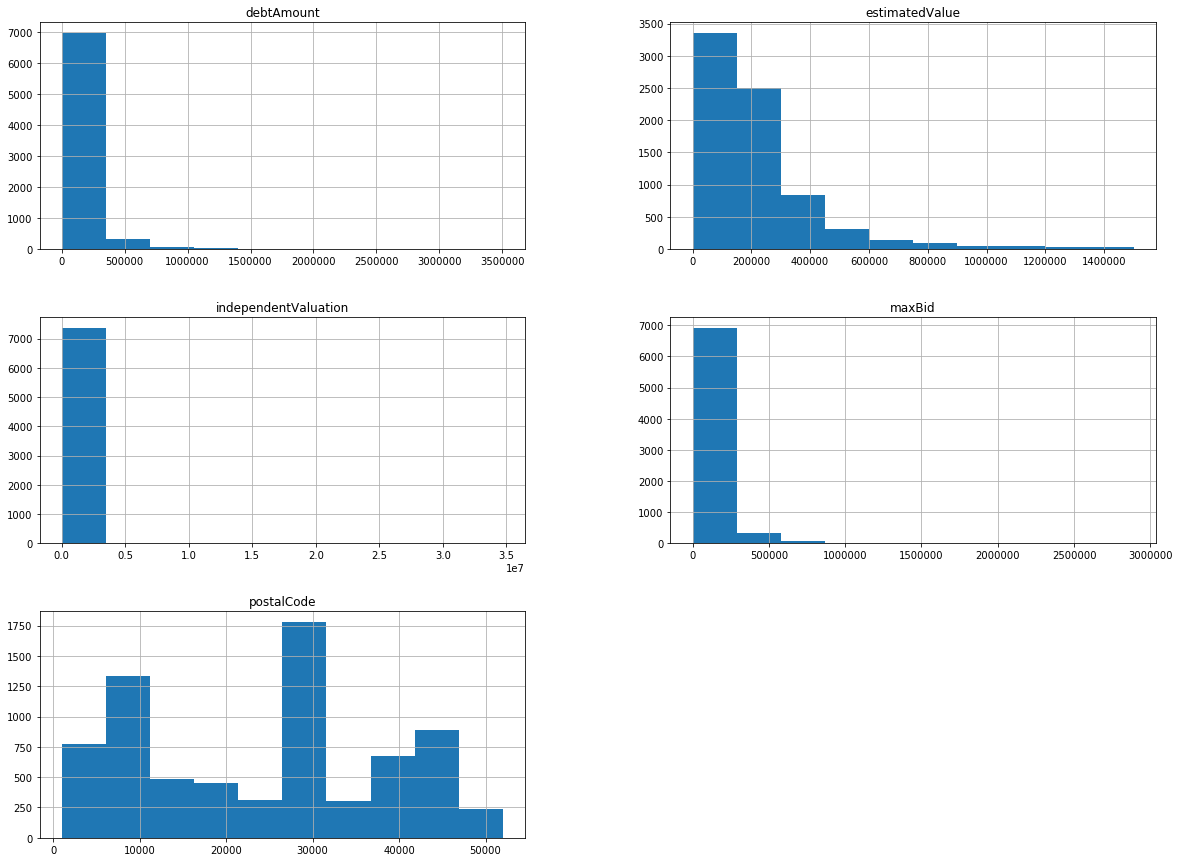

In [261]:
%matplotlib inline

auctions_copy.hist(bins=10, figsize=(20,15))
plt.show()


In [262]:
print(len(auctions_copy["debtAmount"]))


7376
